In [1]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import numpy as np
from matplotlib import pyplot as plt
import time
from tqdm.notebook import trange, tqdm
import pandas as pd
# Pour torch si vous avez un GPU
device = "cpu" if not torch.cuda.is_available() else "cuda"
# device = "cpu" # Pour forcer l'utilisation du CPU

In [2]:
from environnement.environnement import Environnement as env # mother class
from environnement.small_loop import small_loop
from environnement.gridWord import gridWord

# model machine learning
from model.Tokenizer import *
from model.RNN import *
from model.CustomDataSet import CustomDataSet, CustomDataSetRNN
from outil import *
from inter.simpleInteraction import simpleInteraction as inter

# L'agent :
L'idée de se fichier est de mettre en place une exploration guidé. Le principe est de repérer les séquences pour lequel le model de prédicition n'est pas sûr, et de choisir celle qui aurait la meilleur valence. Cette idée ne peut fonctionner que si les séquences sont déterministe.

In [3]:
class AgentLSTM:
    def __init__(self, valence:dict[inter, float], model:nn.Module, max_depth:int, seuil:float,
                optimizer, loss_fn, gap_train:int=11, gap_predi:int=11, nb_epoch:int=100, data_validate=None):
        self.model = model
        self.valence = valence
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.gap_train = gap_train
        self.gap_predi = gap_predi
        self.nb_epoch = nb_epoch
        self.seq_to_exe = [] # Séquence d'actions et d'outcome choisit par la décision
        self.history_act = [] # Historique des actions
        self.history_fb = [] # Historique des feedbacks
        self.history_inter = [] # Historique des interactions
        self.data_validate = data_validate
        self.max_depth:int = max_depth
        self.seuil:float = seuil
        self.force_fit = False
        
        self.all_outcomes = set()
        self.all_act = set()
        key:inter = None
        for key in valence.keys():
            self.all_outcomes.add(key.getOutcome())
            self.all_act.add(key.getAction())
        self.all_outcomes = list(self.all_outcomes)
        self.all_act = list(self.all_act)
        
        self.action_choice = self.all_act[0] # De base nous choisissons la première action
        self.history_act.append(self.action_choice)
        self.outcome_prediction = None # De base le modèl ne prédi rien
        
        # number_patern = np.sum([(len(self.all_act) * len(self.all_outcomes)) **i for i in range(1, (self.max_depth // 2) +1)])
        number_patern = 2000000
        self.prealloc_df = pd.DataFrame(np.empty((number_patern, 5)), columns=["proposition", "valence", "action", "probability", "val_sucess"])
        self.prealloc_df = self.prealloc_df.astype({"proposition": "U20", "valence": float, "action": "U20", "probability": float})
        self.current_index = 0
        
        self.visu_explo = pd.DataFrame(np.empty((number_patern, 2)), columns=["seqence", "valence"])
        self.visu_explo = self.visu_explo.astype({"seqence": "U20", "valence": float})
        self.current_index_explo = 0
        
        self.seq_explo = []
        self.valence_explo = -np.inf
        
        self.visu_val = pd.DataFrame(np.empty((len(data_validate[0]), 3)), columns=["seqence", "probablility", "good"])
        self.visu_val = self.visu_val.astype({"seqence": "U20", "probablility": float, "good": bool})
        
        # Nous avons besoin d'un tokenizer pour transformer les actions et outcomes en entiers
        # Pour des questions de simplicité, nous voulons que les outcomes soient passé en premier
        self.tokenizer = SimpleTokenizerV1(
            vocab={key: i for i, key in enumerate(self.all_outcomes + self.all_act)})
        
        # Variable moniteur
        self.loss_train = [] # Contient toutes les listes des pertes d'entrainement
        self.loss_val = [] # Contient toutes les listes des pertes de validation
        self.acc_train = []
        self.acc_val = []
        
        self.time_train = []
        self.time_compute_expected_valence = []
        self.predictExplo = []
        
        
    def fit(self):
        """
        Fonction de l'agent pour entrainer le modèle
        """        
        dataset = CustomDataSetRNN(actions=self.history_act, outcomes=self.history_fb, 
                                 context_lenght=self.gap_train, dim_out=len(self.all_outcomes),
                                 tokenizer=self.tokenizer)
        
        data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
        
        if self.data_validate is not None:
            dataset_test = CustomDataSetRNN(actions=self.data_validate[0], outcomes=self.data_validate[1], 
                                 context_lenght=self.gap_train, dim_out=len(self.all_outcomes),
                                 tokenizer=self.tokenizer)
            data_loader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)
            loss_test = []
        
        time_train = time.time()
        for i in range(self.nb_epoch):
            self.model.train()
            steps = 0
            train_acc = 0
            training_loss = []
            for tmp, (x,t) in enumerate(data_loader):
                x = x.to(device)
                t = t.to(device)
                bs = t.shape[0]
                h = torch.zeros(self.model.num_layers, bs, self.model.hidden_size, device=device)
                cell = torch.zeros(self.model.num_layers, bs, self.model.hidden_size, device=device)

                pred, h, cell = self.model(x, h, cell)

                loss = self.loss_fn(pred[:, -1, :], t)
                training_loss.append(loss.item())
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                train_acc += sum((pred[:, -1, :].argmax(1) == t).cpu().numpy())
                steps += bs
                
            self.acc_train.append(train_acc / steps)
            # time_val_epoch = time.time()
            if self.data_validate is not None:
                self.model.eval()
                steps = 0
                test_acc = 0
                loss_test = []
                
                for text, label in data_loader_test:
                    text = text.to(device)
                    label = label.to(device)
                    bs = label.shape[0]

                    # Initialize hidden and memory states
                    hidden = torch.zeros(self.model.num_layers, bs, self.model.hidden_size, device=device)
                    memory = torch.zeros(self.model.num_layers, bs, self.model.hidden_size, device=device)
                    
                    # Forward pass through the model
                    pred, hidden, memory = self.model(text, hidden, memory)
                    
                    for i in range(bs):
                        self.visu_val.iloc[steps + i] = [str(self.tokenizer.decode(text[i].cpu().tolist())), 
                                                         float(torch.nn.functional.softmax(pred[i, -1, :], dim=-1).max().item()), 
                                                         int(pred[i, -1, :].argmax().item() == label[i])]

                    # Calculate the loss
                    loss = self.loss_fn(pred[:, -1, :], label)
                    loss_test.append(loss.item())

                    # Calculate test accuracy
                    test_acc +=  sum((pred[:, -1, :].argmax(1) == label).cpu().numpy())
                    steps += bs
                    
                loss_test.append(loss_test)
                self.acc_val.append(test_acc / steps)
                # print(f"Validation time: {time.time() - time_val_epoch}")    
            self.loss_train.append(training_loss)
            # If acc is 100% we stop the training
            if self.acc_train[-1] >= 0.99:
                for _ in range(i, self.nb_epoch):
                    self.acc_train.append(self.acc_train[-1])
                    self.acc_val.append(self.acc_val[-1])
                break
            
        print(f"Training time: {time.time() - time_train}")
        self.time_train.append(time.time() - time_train)
                
    def predict(self, action):
        """
        Fonction de l'agent pour prédire l'outcome en fonction de l'action \
        utilise l'historique des actions et outcomes comme contexte

        Args:
            action : L'action dont on prédit l'outcome 

        Raises:
            Exception: Si l'historique des actions et outcomes est insuffisant

        Returns:
            out : L'outcome prédit
        """        
        # Nous devons recupérer les gap dernières actions/outcomes
        x = []
        for i in range(-(self.gap_predi - 1) // 2, 0, 1):
            x.append(self.history_act[i])
            x.append(self.history_fb[i])
        x.append(action)
        seq_to_pred = self.tokenizer.encode(x)
        # On simule un batch de taille 1
        seq_to_pred = torch.tensor([seq_to_pred], device=device)
        h = torch.zeros(self.model.num_layers, 1, self.model.hidden_size, device=device)
        cell = torch.zeros(self.model.num_layers, 1, self.model.hidden_size, device=device)
        probs, _, _ = self.model(seq_to_pred, h, cell)
        
        pred_feedback = torch.argmax(probs[:, -1, :]).item()
        pred_feedback = self.tokenizer.decode(pred_feedback)
        
        return pred_feedback
    
    def recursif_valance_explo(self, max_depth:int, seq_predi:list = [], valence_succes_pred:float = 0):
        max_depth -= 1
        inter_max, value = max(self.valence.items(), key=lambda y: y[1])
        for _ in range(max_depth):
            seq_predi += [inter_max.getAction(), inter_max.getOutcome()]
            valence_succes_pred += value
        self.visu_explo.iloc[self.current_index_explo] = [str(seq_predi), valence_succes_pred]
        self.current_index_explo += 1
        if valence_succes_pred > self.valence_explo:
            self.seq_explo = seq_predi
            self.valence_explo = valence_succes_pred                    
    
    def recursif_expective_valance(self, context:list, max_depth:int, seuil:float=0.5, proba:float = 1, seq_predi:list = [], valence_pred:float = 0, valence_succes_pred:float = 0):
        """
        Create the list of proposed sequences
        """
        max_depth -= 1
        
        self.model.eval()
        # Compute the expected valence of each action
        for act in self.all_act:
            new_seq = seq_predi + [act]
            seq_to_predict = context + [self.tokenizer.encode(act)]
            
            # print('find seq')
            # print(new_seq)
            # print([i for i in zip(self.history_act, self.history_fb)])
            sub_list = subfinder(self.history_inter, seq_to_predict[-3:])
            # print(sub_list)
            # print(f'for act : {act} and context : {seq_to_predict}')
            if sub_list == []:
                # print('i want explore')
                # Get max valence and outcome associate by act
                inter_max, value = max([(inter(act, out), self.valence[inter(act, out)]) for out in self.all_outcomes], key=lambda y: y[1])
                # print("debug")
                # print('act :', act)
                # print(inter_max)
                # print(value)
                # print('valence_succes_pred :', valence_succes_pred)
                # print('goal :', self.valence_explo)
                new_seq += [inter_max.getOutcome()]
                tmp_value = valence_succes_pred + value
                self.visu_explo.iloc[self.current_index_explo] = [str(new_seq), valence_succes_pred]
                self.current_index_explo += 1
                if tmp_value > self.valence_explo:
                    # print('start new sequence')
                    # print(new_seq)
                    # print('valence')
                    # print(valence_succes_pred)
                    self.seq_explo = new_seq
                    self.valence_explo = valence_succes_pred
                # Nous n'avons jamais vue la séquence, nous choisisont d'imaginer le meilleur sénario
                # print('sequence not seen')
                self.recursif_valance_explo(max_depth=max_depth, seq_predi=new_seq , 
                                            valence_succes_pred=tmp_value)
                continue
            # print('sequence already seen')
            
            seq_to_predict = torch.tensor([seq_to_predict], dtype=torch.int).to(device)

            hidden = torch.zeros(self.model.num_layers, 1, self.model.hidden_size, device=device)
            memory = torch.zeros(self.model.num_layers, 1, self.model.hidden_size, device=device)

            x, _, _ = self.model(seq_to_predict, hidden, memory)
            x = x[0, -1, :]
            # Transforme x into list proba
            probs = torch.nn.functional.softmax(x, dim=0).tolist()
            # for each outcome, record the expected valence
            expected_valence = valence_pred
            for i, out in enumerate(self.all_outcomes):
                tmp_proba = probs[i] * proba
                expected_valence += float(np.round(self.valence[inter(act, out)] * tmp_proba, decimals=4))
            
            for i, out in enumerate(self.all_outcomes):
                visu_val = None
                tmp_new_seq = new_seq + [out]
                tmp_proba = probs[i] * proba
                # If the probability is above a threshold
                sucess_valence = self.valence[inter(act, out)] + valence_succes_pred
                if tmp_proba > seuil:
                    visu_val = expected_valence
                    # If the max_depth is not reached 
                    if max_depth > 0: 
                        # Recursively look for longer sequences
                        new_context = context + self.tokenizer.encode([act, out])
                        self.recursif_expective_valance(context=new_context[2:], max_depth=max_depth, seuil=seuil, 
                            proba=tmp_proba, seq_predi=tmp_new_seq.copy(), valence_pred=expected_valence, valence_succes_pred=sucess_valence)
                    else:
                        self.prealloc_df.iloc[self.current_index] = [str(tmp_new_seq), visu_val, tmp_new_seq[0], tmp_proba, sucess_valence]
                        self.current_index += 1
    
    def expective_valance(self, verbose:bool=False):
        """
        Permet de calculer l'expective valance d'une séquence d'interaction

        Args:
            max_depth (int): _description_
            seuil (float, optional): _description_. Defaults to 0.2.
            verbose (bool, optional): _description_. Defaults to False.
        """
        
        x = []
        for i in range(-(self.gap_predi - 1) // 2, 0, 1):
            x.append(self.history_act[i])
            x.append(self.history_fb[i])
        seq_to_pred = self.tokenizer.encode(x)
        self.prealloc_df[:] = np.empty((len(self.prealloc_df), 5))
        self.prealloc_df["valence"] = -np.inf
        self.current_index = 0
        self.seq_explo = []
        self.valence_explo = -np.inf
        self.visu_explo[:] = np.empty((len(self.visu_explo), 2))
        self.current_index_explo = 0
        return self.recursif_expective_valance(context=seq_to_pred,
                                            max_depth=self.max_depth,
                                            proba=1, seq_predi=[],
                                            seuil=self.seuil)
    def decide(self):
        if self.seq_to_exe and len(self.seq_to_exe) > 1:
            out = self.seq_to_exe.pop(0)
            if out == self.history_fb[-1]:
                self.predictExplo.append(self.predictExplo[-1])
                act = self.seq_to_exe.pop(0)
                return act
            else:
                self.force_fit = True
        self.seq_to_exe = []        
        
        time_compute_expective_val = time.time()
        self.expective_valance()
        print(f"Time to compute expective valance: {time.time() - time_compute_expective_val}")
        self.time_compute_expected_valence.append(time.time() - time_compute_expective_val)
        # Keep row with probability between 0.4 and 0.6
        # compute_df = self.prealloc_df[(self.prealloc_df["probability"] > 0.3) & (self.prealloc_df["probability"] < 0.7)]
        # if len(compute_df) == 0:
        self.seq_to_exe = self.prealloc_df.sort_values(by="valence", ascending=False).iloc[0].proposition
        expected_val = self.prealloc_df.sort_values(by="valence", ascending=False).iloc[0].valence
        # else: 
            # print("renforce ...")
            # self.seq_to_exe = compute_df.sort_values(by="val_sucess", ascending=False).iloc[0].proposition
            # self.force_fit = True
        print(f"expected valence : {expected_val:.2f} valence explo : {self.valence_explo:.2f} model predict : {self.seq_to_exe}, explo want : {self.seq_explo}")
        # tempo
        if self.seq_to_exe is not None and expected_val > self.valence_explo:
            self.seq_to_exe = eval(self.seq_to_exe)
            print("\033[0;35m after compute ... \033[0m", self.seq_to_exe)
            self.predictExplo.append(1)
        else:
            print("\033[0;36m explo ... \033[0m", self.seq_explo)
            self.seq_to_exe = self.seq_explo
            self.force_fit = True
            self.predictExplo.append(0)
        act = self.seq_to_exe.pop(0)
        return act
        
    def action(self, real_outcome, verbose=False, explore:bool=False):
        """
        La fonction action permet à l'agent de choisir une action en fonction de l'outcome réel.
        Cette fonction entraine le modèle a prévoir les outcomes futurs en fonction des actions passées.

        Args:
            real_outcome : L'outcome réel suite à l'action de l'agent
            verbose : Affiche les informations sur l'entrainement ou non
        """
        # La première étape est de sauvegarder l'outcome réel
        self.history_fb.append(real_outcome)
        self.history_inter.append(self.tokenizer.encode(real_outcome))
        good_pred:bool = self.outcome_prediction == real_outcome
        if verbose :
            print(f"\033[0;31m Action: {self.action_choice} \033[0m, Prediction: {self.outcome_prediction}, Outcome: {real_outcome}, \033[0;31m Satisfaction: {good_pred} \033[0m")
        
        # Ensuite nous regardons si nous devons entrainer le modèle
        # not(explore) and 
        if (not(good_pred) or self.force_fit)and len(self.history_fb) + len(self.history_fb) > self.gap_train:
            self.fit()
            self.force_fit = False
            
        elif len(self.history_fb) + len(self.history_fb) > self.gap_train:
            for _ in range(self.nb_epoch):
                self.acc_train.append(self.acc_train[-1])
                self.acc_val.append(self.acc_val[-1])

        # Nous devons maintenant choisir une action
        if len(self.history_fb) + len(self.history_fb) > self.gap_predi:
            self.action_choice = self.decide()
            self.outcome_prediction = self.predict(self.action_choice)
        else:
            inter_max, value = max(self.valence.items(), key=lambda y: y[1])
            self.action_choice = inter_max.getAction()
        # self.action_choice = np.random.choice(self.all_act)
        self.history_act.append(self.action_choice)
        self.history_inter.append(self.tokenizer.encode(self.action_choice))
        
        return self.action_choice, self.outcome_prediction
        
        
              

In [4]:
# environenment = small_loop(x=1, y=1, theta=0, world=np.array([
#                 [1, 1, 1, 1, 1],
#                 [1, 0, 0, 0, 1],
#                 [1, 0, 1, 0, 1],
#                 [1, 0, 0, 0, 1],
#                 [1, 1, 1, 1, 1],
#             ]))

# environenment = small_loop(x=1, y=1, theta=0, world=np.array([
#                 [1, 1, 1, 1, 1, 1],
#                 [1, 0, 0, 0, 1, 1],
#                 [1, 0, 1, 0, 0, 1],
#                 [1, 0, 1, 1, 0, 1],
#                 [1, 0, 0, 0, 0, 1],
#                 [1, 1, 1, 1, 1, 1],
#             ]))

# environenment = small_loop(x=1, y=1, theta=0, world=np.array([
#                 [1, 1, 1, 1, 1, 1],
#                 [1, 0, 0, 0, 0, 1],
#                 [1, 0, 0, 0, 0, 1],
#                 [1, 0, 0, 0, 0, 1],
#                 [1, 0, 0, 0, 0, 1],
#                 [1, 1, 1, 1, 1, 1],
#             ]))

# valence = {
#     inter('forward', 'empty') : 10,
#     inter('forward', 'wall') : -100,
#     inter('turn_left', 'empty') : -21,
#     inter('turn_left', 'wall') : -100,
#     inter('turn_right', 'empty') : -21,
#     inter('turn_right', 'wall') : -100,
#     inter('feel_front', 'wall') : -15,
#     inter('feel_front', 'empty') : -12,
# }

In [5]:
environenment = gridWord(x=1, y=1, theta=0, world=np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 1, 1, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

valence = {
    inter('forward', 'empty') : 10,
    inter('forward', 'wall') : -100,
    inter('turn_left', 'empty') : -21,
    inter('turn_left', 'wall') : -100,
    inter('turn_right', 'empty') : -21,
    inter('turn_right', 'wall') : -100,
    inter('feel_front', 'wall') : -15,
    inter('feel_front', 'empty') : -12,
    inter('feel_right', 'wall') : -15,
    inter('feel_right', 'empty') : -12,
    inter('feel_left', 'wall') : -15,
    inter('feel_left', 'empty') : -12   
}

In [6]:
# torch.manual_seed(0)
# np.random.seed(0)
hidden_size = 16
num_layers = 1
len_vocab = len(environenment.get_outcomes() + environenment.get_actions())

# Create the LSTM classifier model
lstm_classifier = LSTM(num_emb=len_vocab, output_size=2, 
                       num_layers=num_layers, hidden_size=hidden_size, dropout=0.5).to(device)

optimizer = torch.optim.Adam(lstm_classifier.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
tokenizer = SimpleTokenizerV1(create_dico_numerate_word(environenment.get_outcomes() + environenment.get_actions()))

/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [7]:
# Pour évaluler la performance du modèle
act_val, fb_val = [], []
for i in trange(1000):
    action = np.random.choice(environenment.get_actions())
    outcome = environenment.outcome(action)
    act_val.append(action)
    fb_val.append(outcome)

  0%|          | 0/1000 [00:00<?, ?it/s]

# Init model

In [8]:
agent = AgentLSTM(valence=valence, model=lstm_classifier, optimizer=optimizer, loss_fn=loss_func,
    gap_predi=7, gap_train=7, max_depth=5, seuil=0.3, nb_epoch=20,
    data_validate=(act_val, fb_val))

In [9]:
history_good = []
history_good_inter = []
history_bad_inter = []
hisrory_val = []
pourcent_by_10  = []
by_10_good_inter  = []
by_10_bad_inter  = []
mean_val = []


In [ ]:
# torch.manual_seed(0)
# np.random.seed(0)

outcome = environenment.outcome(agent.action_choice)

for i in tqdm(range(100)):
    action, predi = agent.action(outcome, verbose=True)
    
    outcome = environenment.outcome(action)
    history_good.append(outcome == predi)
    history_good_inter.append((action == 'forward' and outcome == 'empty'))
    history_bad_inter.append((action == 'forward' and outcome == 'wall'))
    hisrory_val.append(valence[inter(action, outcome)])
    pourcent_by_10.append(sum(history_good[-10:]) if len(history_good) >= 10 else 0)
    by_10_good_inter.append(sum(history_good_inter[-10:]) if len(history_good_inter) >= 10 else 0)
    by_10_bad_inter.append(sum(history_bad_inter[-10:]) if len(history_bad_inter) >= 10 else 0)
    mean_val.append(np.mean(hisrory_val[-10:]) / 10 if len(hisrory_val) >= 10 else 0)
    environenment.save_world(path="imgToGif3")
    

agent.prealloc_df.to_csv("prealloc_df.csv")
agent.visu_val.to_csv("df_val.csv")
agent.visu_explo.to_csv("df_explo.csv")

pourcent_by_10 = pourcent_by_10[10:]
by_10_good_inter = by_10_good_inter[10:]
by_10_bad_inter = by_10_bad_inter[10:]
mean_val = mean_val[10:]

  0%|          | 0/100 [00:00<?, ?it/s]

 Action: forward , Prediction: None, Outcome: wall,  Satisfaction: False 
 Action: forward , Prediction: None, Outcome: wall,  Satisfaction: False 
 Action: forward , Prediction: None, Outcome: wall,  Satisfaction: False 
 Action: forward , Prediction: None, Outcome: wall,  Satisfaction: False 


/tmp/ipykernel_11784/4006124349.py:128: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.visu_val.iloc[steps + i] = [str(self.tokenizer.decode(text[i].cpu().tolist())),


Training time: 0.682765007019043
Time to compute expective valance: 0.09362912178039551
expected valence : -inf valence explo : 40.00 model predict : 0.0, explo want : ['forward', 'empty', 'forward', 'empty', 'forward', 'empty', 'forward', 'empty']
 explo ...  ['forward', 'empty', 'forward', 'empty', 'forward', 'empty', 'forward', 'empty']
 Action: forward , Prediction: wall, Outcome: wall,  Satisfaction: True 
Training time: 0.411942720413208
Time to compute expective valance: 0.08363890647888184
expected valence : -inf valence explo : 40.00 model predict : 0.0, explo want : ['forward', 'empty', 'forward', 'empty', 'forward', 'empty', 'forward', 'empty']
 explo ...  ['forward', 'empty', 'forward', 'empty', 'forward', 'empty', 'forward', 'empty']
 Action: forward , Prediction: wall, Outcome: wall,  Satisfaction: True 
Training time: 0.3838925361633301
Time to compute expective valance: 0.06047654151916504
expected valence : -inf valence explo : 40.00 model predict : 0.0, explo want : [

In [24]:
for i in tqdm(range(200)):
    action, predi = agent.action(outcome, verbose=True)
    df2 = agent.prealloc_df
    df_val2 = agent.visu_val
    df_explo2 = agent.visu_explo
    outcome = environenment.outcome(action)
    history_good.append(outcome == predi)
    history_good_inter.append((action == 'forward' and outcome == 'empty'))
    history_bad_inter.append((action == 'forward' and outcome == 'wall'))
    hisrory_val.append(valence[inter(action, outcome)])
    pourcent_by_10.append(sum(history_good[-10:]) if len(history_good) >= 10 else 0)
    by_10_good_inter.append(sum(history_good_inter[-10:]) if len(history_good_inter) >= 10 else 0)
    by_10_bad_inter.append(sum(history_bad_inter[-10:]) if len(history_bad_inter) >= 10 else 0)
    mean_val.append(np.mean(hisrory_val[-10:]) / 10 if len(hisrory_val) >= 10 else 0)
    environenment.save_world("imgToGif3")

  0%|          | 0/200 [00:00<?, ?it/s]

 Action: forward , Prediction: empty, Outcome: wall,  Satisfaction: False 
Training time: 10.035890817642212
Time to compute expective valance: 7.235642433166504
expected valence : -39.23 valence explo : -135.00 model predict : ['turn_right', 'empty', 'feel_front', 'empty', 'feel_left', 'empty', 'forward', 'empty', 'forward', 'empty'], explo want : ['feel_left', 'empty', 'feel_left', 'empty', 'turn_right', 'empty', 'turn_right', 'wall', 'forward', 'empty']
 after compute ...  ['turn_right', 'empty', 'feel_front', 'empty', 'feel_left', 'empty', 'forward', 'empty', 'forward', 'empty']
 Action: turn_right , Prediction: empty, Outcome: empty,  Satisfaction: True 
 Action: feel_front , Prediction: empty, Outcome: empty,  Satisfaction: True 
 Action: feel_left , Prediction: wall, Outcome: wall,  Satisfaction: True 
Time to compute expective valance: 7.719388484954834
expected valence : -24.19 valence explo : -135.00 model predict : ['feel_front', 'wall', 'feel_right', 'empty', 'turn_right', 

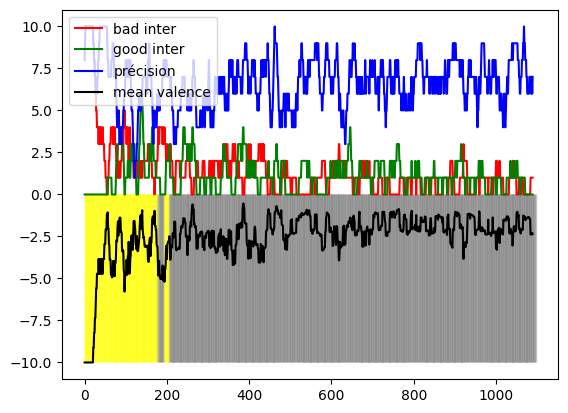

In [25]:
# Function to map integers to colors
def int_to_color(value):
    if value == 0:
        return "yellow"
    return "gray"

# Create a figure and axis
fig, ax = plt.subplots()

#1 / (len(by_10_bad_inter) -10)
for i, value in enumerate(agent.predictExplo):
    ax.add_patch(plt.Rectangle((i, -10), 0.1, 10, color=int_to_color(value), alpha=0.4))

# Plot the data
plt.plot(by_10_bad_inter, label='bad inter', color='red')
plt.plot(by_10_good_inter, label='good inter', color='green')
plt.plot(pourcent_by_10, label='précision', color='blue')
plt.plot(mean_val, label='mean valence', color='black')

# Add legend
plt.legend()

# Show the plot
plt.show()

# Close the plot
plt.close()


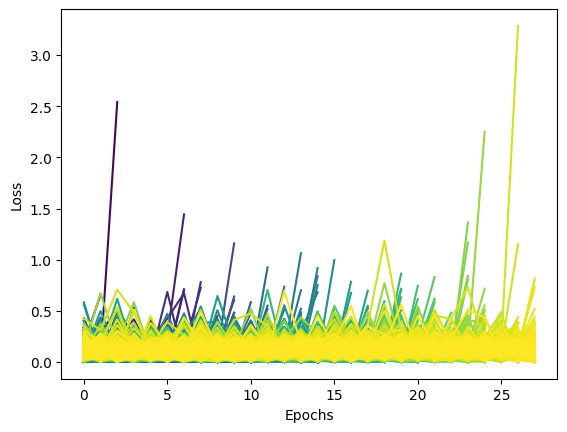

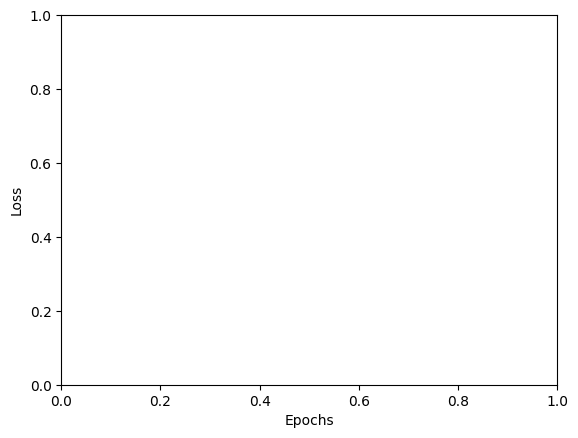

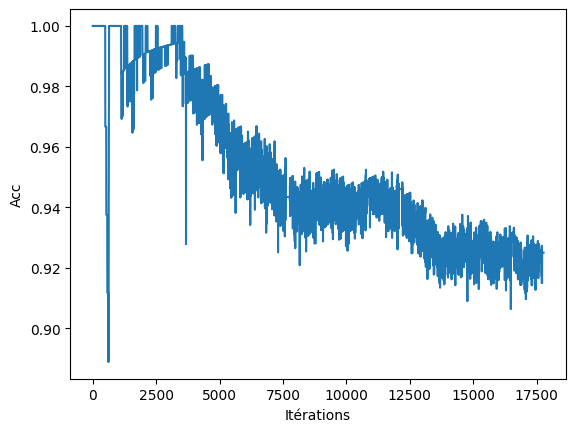

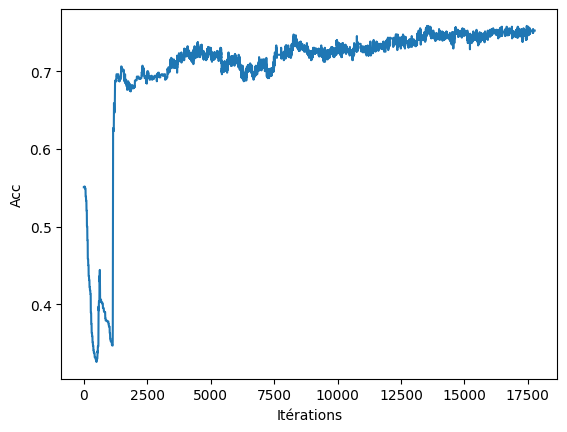

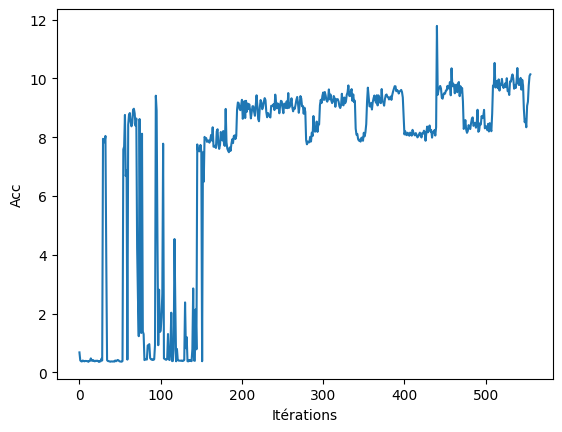

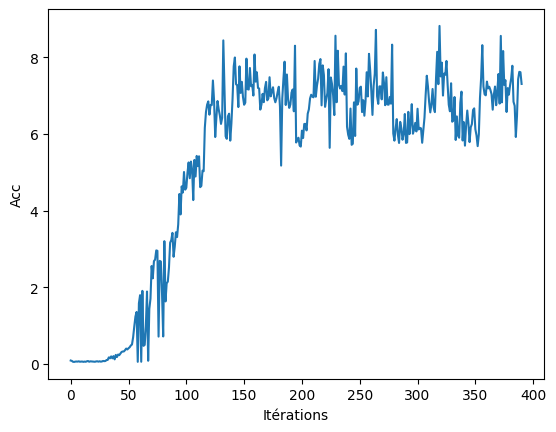

In [23]:
see_evolued_loss(agent.loss_train)
see_evolued_loss(agent.loss_val)
see_evolued_acc(agent.acc_train)
see_evolued_acc(agent.acc_val)

see_evolued_acc(agent.time_train)
see_evolued_acc(agent.time_compute_expected_valence)




In [14]:
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import plotly.offline as py

# Get weights
embds = agent.model.embedding.weight.detach().cpu().numpy()

# Plotting function
def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x = data[start:stop:step, 0], 
        y = data[start:stop:step, 1],
        mode = 'markers',
        text = [tokenizer.decode(i) for i in range(start, stop, step)]
    )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)
    py.iplot(fig)

# Visualize words in two dimensions 
# Set perplexity to a value less than the number of samples
perplexity_value = min(30, len(embds) - 1)  # Ensure perplexity is less than the number of samples
conv_tsne_embds = TSNE(n_components=2, perplexity=5).fit_transform(embds)
plot_words(conv_tsne_embds, 0, len(embds), 1)